In [1]:
from typing import Any

# Define symbols

In [44]:
class Method:
    INTEGRATION = 1
    QSP = 2
    DIRECT = 3
    INTEGRATION_EXACT = 4

In [3]:
# K = 331.68#190
# S0 = 189.12
# dt = 250
# 
# COV = 0.000335
# MU_LOG_RET = 0.00050963
# 
# MU_VAL = MU_LOG_RET * dt
# SIGMA = sp.sqrt(COV) * sp.sqrt(dt)

# values_map = {e_payoff: 0.1, T: 20, d:1, S0: 900, K: 950, SIGMA: 0.2}#, MU: 0.2, S0: 189.12} # TODO remove this line

# Basic Depth

In [45]:
def D_Ry(error: Any, controlled = False) -> Any:
    if controlled:
        return 2*3*np.log2(2/error)
    else:
        return 3*np.log2(1/error)

def D_Rz(error: Any) -> Any:
    return np.log2(1/error)

def D_Toffoli() -> Any:
    return 3

def D_mcx(controls: Any) -> Any:
    if controls==2:
        return D_Toffoli()
    return 14*np.emath.logn(3,controls/2)+5

def D_cswap() -> Any:
    return 4

In [46]:
def D_zero_payoff(error, controlled=True) -> Any:
    return D_Ry(error=error,controlled=controlled) # MCX of MCRY already counted in the arithmetic

def D_binary_payoff(error) -> Any:
    return D_Ry(error=error,controlled=True) # MCX of MCRY already counted in the arithmetic

# Rescaling


## QSP Rescaling

### Polynomial Creation for QSP Transformation

The goal is to approximate the function used in the quantum state preparation via a polynomial transformation in the QSP method. The target function is:

$$
f(x) = \sqrt{1 - \left(K_T - e^{x2^{2p} e^{-s}}\right)}.
$$

#### Key Steps in Polynomial Transformation:

1. **State Preparation with $ U_{\text{sqrt}} $**:
   The unitary $ U_{\text{sqrt}} $ generates the intermediate quantum state:
   $$
   U_{\text{sqrt}} \, |r_T + s\rangle_m |0\rangle_{m+1} = |r_T + s\rangle_m \left( \sqrt{\frac{r_T + s}{2^p}} |\psi_0\rangle |0\rangle + \sqrt{1 - \frac{r_T + s}{2^p}} |\psi_1\rangle |0_\perp\rangle \right),
   $$
   where $ s \geq \max(|r_T|) $ ensures normalization.

2. **Polynomial Approximation**:
   The QSP method uses a polynomial $ P(x) $ to approximate the function $ f(x) $. The polynomial must accurately represent:
   $$
   P(x) \approx \sqrt{1 - \left(K_T - e^{x2^{2p} e^{-s}}\right)}.
   $$
   This ensures the correct transformation is applied for the computation of the payoff clause.

3. **Normalization Condition**:
   The values are constrained such that:
   $$
   1 - \left(K_T - e^{x2^{2p} e^{-s}}\right) \in [0, 1].
   $$

The polynomial $ P(x) $ is carefully constructed to ensure efficient implementation in quantum circuits while maintaining accuracy for the square root transformation.

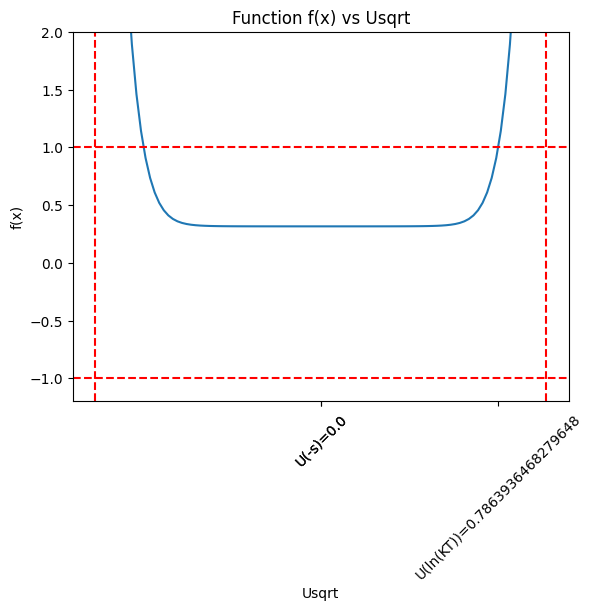

In [47]:
# let's draw a plot, where the x-axis is the value of Usqrt (which is sqrt((rT+s)/2^p)) and the y-axis is the value of the function f(x) = sqrt(1 - (KT - e^(x*2^(2p)*e^(-s))))
import matplotlib.pyplot as plt
import numpy as np

# define the x values
u_sqrt = np.linspace(-1, 1, 100)
KT = 0.9 # return space, assumed in [0,1]
s = 10 # the max(|rT|) - shift of the log-return to start from zero
p = 4 # digits for the integer part in log-return space. Division by 2**p is making the shifted log return to be in [0,1]

def Usqrt(rT): # transormation from the log-return space to [0,1]
    return np.sqrt((rT+s)/2**p)

# define the function
def f(x, KT, s):
    return np.sqrt(1 - (KT - np.exp(x**2*(2**p))*np.exp(-s)))

plt.plot(u_sqrt, f(u_sqrt, KT, s))
plt.xlabel('Usqrt')
plt.ylabel('f(x)')
plt.title('Function f(x) vs Usqrt')
#add ticks for the x-axis for x in rT=-s, rT=ln(KT)
plt.xticks([0, Usqrt(-s), Usqrt(np.log(KT))], ['0', f'U(-s)={Usqrt(-s)}', f'U(ln(KT))={Usqrt(np.log(KT))}'])
# make the ticks label diagonal
plt.xticks(rotation=45)
# add vertical lines for x=+/-1 and horizontal for y=+/-1
plt.axvline(-1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
# limit the y-axis to [-1, 1]
plt.ylim(-1.2, 2)
plt.show()

For the price space we only need to rescale by factor of S0


In [48]:
def rescaling(method: Method, S_min_val=None, S_max_val=None, K_val=None, S0_value=None) -> Any:

    if method == Method.INTEGRATION:
        # based on the integration method
        # Smax-S_L for Samimi European
        return float(np.abs(S_max_val - S_min_val)) # we can update to the exact formula, but this is close enough
    elif method == Method.INTEGRATION_EXACT:
        return float(np.abs(K_val - S_min_val)) # we can update to the exact formula, but this is close enough
    elif method == Method.QSP:
        return float(S0_value)
    elif method == Method.DIRECT:
        return float(np.abs(S_max_val))


# State Preparation

## Errors in State Preparation

The total error in the re-parameterization approach is given by:

$$
\frac{\epsilon_{\text{total}}}{f_\delta} \leq \epsilon_{\text{trunc}} + \epsilon_{\text{disc}} + \epsilon_{\text{arith}} + \epsilon_{\text{amp}},
\tag{42}
$$

where:

* $f_δ = f^{disc}_{max} −f^{disc}_{min}$ is the rescaling in the article context

This error analysis is detailed in [1].

[1] Montanaro, A., & Pallister, S. (2020). *Quantum algorithms and the finite element method*. Retrieved from [https://arxiv.org/pdf/2012.03819](https://arxiv.org/pdf/2012.03819).

### $\epsilon_{\text{trunc}}$

The price of a derivative is determined by an integral over all the possible values of the underlying price (or return). Given finite quantum memory, we cannot feasibly compute an integral over an infinite domain, and thus we restrict the domain of integration as follows: the prices/log-returns are restricted to a range $[B_l,B_u]$.

This restriction of the domain leaves out a probability mass of $α$.

Given an upper bound of $P_{max}$ on the density functions at each step and an upper bound $f_δ$ on the discounted payoff, we incur a truncation error which we denote by $ϵ_{trunc} = P^T_{max} f_δ α$.

Denote the maximum eigenvalue of the covariance matrix $\Sigma$ by $\sigma_{\text{max}}$.

Using Chernoff tail bounds on Gaussians, the probability that the log-returns for asset $i$ lie outside of the interval $[\mu_i - w\sigma_{\text{max}}, \mu_i + w\sigma_{\text{max}}]$ is upper bounded by $2e^{-w^2/2}$. By the union bound, the probability that any log-return ($d$ assets over $T$ time steps) lies outside the interval

$$[B_l = (r - 0.5\sigma_{\text{max}}^2)\Delta t - w\sigma_{\text{max}},
B_u = (r - 0.5\sigma_{\text{max}}^2)\Delta t + w\sigma_{\text{max}}]$$

is upper bounded by $2dTe^{-w^2/2}$.

Let the initial asset prices lie in the range $[S^0_{\text{min}}, S^0_{\text{max}}]$. Then the corresponding interval in price space is given by $[S^0_{\text{min}} e^{B_l T}, S^0_{\text{max}} e^{B_u T}]$. We can then define the truncated window of values for our $dT$ different $n$-qubit registers that are $w$ standard deviations around the mean for each time step. The truncation error of the integral already normalized by $P_{\text{max}}^T f_\delta$ is then given by:

$$
\epsilon_{\text{trunc}} \leq 2dTe^{-w^2/2}.
$$

(Not include the rescaling)

Now, in the case of integration, the demand on $\epsilon_{\text{trunc}}$ depend on $S_{\text{min}}$ which is determined by the rescaling. $S_{min}$ affect $w$ too, so we would like to write them in one equation.

$$
\epsilon_{\text{trunc}}
=
\frac{\epsilon_{payoff}}{K-S_{\text{min}}}
=
\frac{\epsilon_{payoff}}{K-S_{0}e^{-w\sigma}}
\leq 2dTe^{-w^2/2}
$$

Now we can solve this equation to find the $w$ that satisfy the equation. We need to solve it numerically, as it is not a simple equation to solve.

Search the equality. Let's build $f(w)$ by multiplying the right side by $K-S_{0}e^{-w\sigma}$ and subtracting the left side. Then we can find the root of this function.

$$
f(w) = 2dTe^{-w^2/2}(K-S_{0}e^{-w\sigma}) - \epsilon_{payoff}
$$




In [49]:
import numpy as np

# The code is inside Complexity class
def trunc_error(stds_around_mean_to_include, _d, _T):
    return 2*_d*_T*np.exp(-stds_around_mean_to_include**2/2)

def stds_around_mean_to_include_func(error_trunc, _d, _T):
    return np.sqrt(2*np.log(2*_d*_T/error_trunc))

# TODO - OK? - add T into account, check in the article
#TODO - OK? - check (_K-_S0*np.exp(-_w*_sigma))
def find_w_integ(_e_payoff, _d, _T, _S0, _K, _sigma, reduce_factor=0.99, w_precision=1E-5):
    def lhs(_w):
        return _e_payoff/(_K-_S0*np.exp(-_w*_sigma))
    def rhs(_w):
        return trunc_error(_w, _d, _T)
    # solve numerically, assuming 0<w<10/sigma. Start from max value, it will give lhs>rhs, and reduce until lhs<rhs, and increase precision
    _w = 10/_sigma
    # first rough estimation
    while lhs(_w) > rhs(_w):
        _w *= reduce_factor
    # fine estimation
    w_big = _w/reduce_factor
    w_small = _w
    # search until the precision is reached |w_small-w_big|<w_precision
    while np.abs(w_small-w_big)>w_precision:
        _w = (w_small+w_big)/2
        if lhs(_w) > rhs(_w):
            w_big = _w
        else:
            w_small = _w

    return _w

# test for d=10, T=20, S0=850, K=900, sigma=0.02
find_w_integ(0.1, 100, 2000, 850, 900, 0.02, reduce_factor=0.99, w_precision=1E-7)


6.359642624920527

We should now notice, that even though $S_{\text{min}}$ and $S_{\text{max}}$ are determining $w$ because of the rescaling,, the resulted $S_{min}$ and $S_{max}$ are derived again from $w$
So in not many iterations of re-assuming the values, we should get the same $S_{min}$ and $S_{max}$.
Let's assume just one iteration for simplicity.

### $\epsilon_{\text{disc}}$

This error (denoted by $ϵ_{disc}$) arises from the use of a Riemann Sum over a finite grid of points to approximate the integral. This error can be reduced by increasing the number of qubits (n) to approximate the sum

We assume that each underlying asset/return is restricted to an interval $[B_l,B_u]$

#### How to calculate the error?

* The full domain is divided into $2^{k d t}$ cells
* Corresponding to each value of the register we associate the value of the integrand at the midpoint of the corresponding cell. Assume that $β$ provides an upper bound on the second derivatives of the integrand (this can be restated as saying that the deviation from linearity over a range of length $l=[B_l,B_u]/2^k$ is bounded by $βl^2/2$)
* Since this is gaussian
* Each cell has length of $l$  and is a hyper cube of dimension $l$
* By symmetry that the linear component of the deviation from the value at the center of the cell integrates to 0 over the cell.
* The error in each cell can thus be bounded by the integral of the term $βx^2/2$ over a $dT$-hypercube of side length $l$ centered at the origin.
* the total discretization error is bounded by:

$$
\epsilon_{disc} \leq \frac{\beta (2w\sigma_{\text{max}})^{dT + 2}}{24 \cdot 2^{2k}}
$$

Where this is actually might be a wrong calculation in the article, as the actual one is written in my notebook handwritten, by Eyal help. TODO

For a target discretization error, Eq. (23) also gives us the total number of qubits required to represent d assets for T timesteps, given by:

$$
k = \lceil \frac{1}{2} \left( \log_2(\beta / 24) - \log_2(\epsilon_{\text{disc}}) + (dT + 2) \log_2(2w\sigma_{\text{max}}) \right) \rceil
$$

#### Clac $\beta$ (Upper Bound on Second Derivative of a Gaussian)


- The second derivative of the Gaussian distribution $ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}} $ is:
 $$
  f''(x) = \frac{1}{\sqrt{2\pi}\sigma^5} \left( x^2 - \sigma^2 \right) e^{-\frac{x^2}{2\sigma^2}}
 $$

$\beta $ is the maximum magnitude of $ f''(x) $ over the truncated range $ x \in [-w\sigma, w\sigma] $:
$$
  \beta = \max_{x \in [-w\sigma, w\sigma]} \left| f''(x) \right|
$$

It is maximal when x=0, so $\beta = \frac{1}{\sqrt{2\pi}\sigma^3}$

In [50]:
def log_return_to_price(log_return, S0):
    return S0*np.exp(log_return)

def price_to_log_return(price, S0):
    return np.log(price/S0)

In [51]:
def beta_func(sigma_, d_, T_) -> Any:
    # return 1/(np.sqrt(2*np.pi)*sigma_**3) # TODO - OK? - fix tis mistake, this should be of integrand of d*T gaussians, not gaussian
    return 1/(np.sqrt(2*np.pi)*sigma)**(d_*T_)/(sigma_**2)

In [52]:
def disc_error(beta_, w_, d_, T_, sigma_max_, k_) -> Any:
    return (beta_*(2*w_*sigma_max_)**(d_*T_ + 2))/(24*2**(2*k_))

def k_disc_func(beta_, error, w_, d_, T_, sigma_max_) -> Any:
    k = np.ceil(
            0.5*(
             np.log2(beta_/24)
             - np.log2(error)
             + (d_*T_ + 2)*np.log2(2*w_*sigma_max_)
            )
        )
    if k<1:
        raise Warning(f"negative k {k} beta_, error, w_, d_, T_, sigma_max \n {beta_, error, w_, d_, T_, sigma_max_}")
        pass
    return max(k,2)

In [53]:
#QSP article
sigma = 1 # Arbitrary since it doesn't matter.
T=20
d=3
beta = beta_func(sigma_=sigma, d_=d, T_=T)
disc_error(beta, w_=3, d_=d, T_=T, sigma_max_=sigma, k_=15)

np.float64(77423065245036.84)

In [29]:
k_disc_func(beta_=0.000000001, error=1E-1, w_=5, d_=d, T_=T, sigma_max_=0.4)


np.float64(47.0)

In [54]:
def D_sp(error_dense, n) -> Any:
    # Naive
    # return sp.log(1/error)**3.97

    # return 0

    # https://arxiv.org/pdf/2012.03819 p35 assuming they have a mistake and *n should not happen - OK?
    L = 0.14*n*np.log2(1/error_dense)
    return D_Ry(error=error_dense/n)*(L+1)
    # TODO - OK? - check the QSP numbers
    # Samimi approach TODO, depends on the sigma, mu - filling factor
    # return D_mul(n) + D_Ry(error=error/n) + D_mcx(controls=n)

### $\epsilon_{\text{arith}}$

Arises from the individual errors introduced during the preparation of the Gaussians and the calculation of the payoff.

Assuming that each Gaussian $g(x_i)$ prepared has $L_\infty$ error $\epsilon_{\text{dens}}$ and the payoff calculation introduces a maximum error of $\epsilon_f$, the total error is given by:

$$
\epsilon_{\text{arith}} = \sum_{x_1=-w}^{w} \cdots \sum_{x_{dT}=-w}^{w}
\underbrace{\left[
\prod_{i=1}^{dT} \left( g(x_i) + \epsilon_{\text{dens}} \right) \left( f(x) + \epsilon_f \right) -
\prod_{i=1}^{dT} g(x_i) f(x)
\right]}_{\text{Error term}}
\tag{43}
$$

where $\mathbf{x} = (x_1, x_2, \ldots, x_{dT})$.

Expanding the integrand and keeping only the linear error terms, we get:

$$
\epsilon_{\text{arith}} \leq 2w dT \epsilon_{\text{dens}} + \epsilon_f,
\tag{44}
$$

where we use that $\sum_{x=-w}^{w} g(x) \leq 1$ due to truncation of the probability mass function.

$\epsilon_{f}$ is the error of QAE actually, which is the only factor causing this error in the final payoff calculation.

In [55]:
def arith_error(error_dense, error_qae, stds_to_include,d_, T_) -> Any:
    return 2*stds_to_include*d_*T_*error_dense + error_qae

# Arithmetic

In [102]:
from amplitude_loading_toy_model.integration_exact_tools import find_k_m_xKtag


# https://arxiv.org/abs/quant-ph/0406142 p19
def D_comp(n: Any, controlled=False) -> Any:
    # case controlled, since shape is UVUdag, control is only on 1 Toffoli in the middle
    return (2*np.log2(n)+5)*D_Toffoli() + int(controlled)*(D_mcx(controls=3)-D_Toffoli())

# https://arxiv.org/pdf/1805.12445
# T_exp = sp.symbols('T_{exp}', positive=True)
# def T_exp_func(error, n) -> Any:
    # In the case of arithemtic as in https://arxiv.org/pdf/2012.03819
    # return D_Toffoli()*500*n**2*sp.log(1/error,2)**1.5

def D_add(n) -> Any:
    # https://arxiv.org/abs/quant-ph/0406142 p19
    return (2*np.log2(n)+5)*D_Toffoli()

    #  https://arxiv.org/pdf/2012.03819 p28
    # return (sp.floor(sp.log(n,2)) + sp.floor(sp.log(n-1,2)) +sp.floor(sp.log(n/3,2)) + sp.floor(sp.log((n-1)/3,2)) +8)*D_Toffoli()

def D_mul(n) -> Any:
    # https://www.mdpi.com/1424-8220/23/6/3156#:~:text=The%20quantum%20multiplication%20circuit%20that,the%20field%20size%202%20n%20.
    # return (3*n-2)*D_Toffoli()

    #  https://arxiv.org/pdf/2012.03819 p28
    z=1
    return (n/z)*(D_add(n)+6) + np.log2(z)*D_add(n)


# https://arxiv.org/pdf/2012.03819 p35 - assuming d=1, just T additions, including S0 + affine mul SIGMA + MCX for zero_payoff and payoff (else case) in final_payoff
# TODO in QMOD - MU can move to the constant comparator and save addition
# TODO in QMOD - check next K oly if last K did not cross rather than every K fully
def D_arith(error_,n_, method: Method, d_, T_) -> Any:
    if method == Method.INTEGRATION or method == Method.INTEGRATION_EXACT:
        return (
                    d_*D_mul(n_) + # SIGMA mul
                    (
                        (T_-1)*(D_add(n_)+D_comp(n_))+
                        (T_-1)*(
                            np.max([
                                D_comp(n_),
                                D_binary_payoff(error=error_)  + D_Toffoli() #+ D_mcx(i) possible too
                            ])
                        )

                    ) +
                    D_mcx(controls=T_-1) + # zero_payoff MCX
                    int(d_-1).bit_length()*(D_comp(n_)+n_*D_cswap())
                )
    if method == Method.QSP:
        return (
                    d_*D_mul(n_) + # SIGMA mul
                    (
                        (T_-1)*(D_add(n_)+D_comp(n_))+
                        (T_-1)*(
                            sum([
                                D_comp(n_),
                                D_binary_payoff(error=error_)  + D_Toffoli() #+ D_mcx(i) possible too
                            ])
                        )

                    ) +
                    D_mcx(controls=T_-1) + # zero_payoff MCX
                    int(d_-1).bit_length()*(D_comp(n_)+n_*D_cswap())
                )
 

# QAE

# Amplitude Loading

## QSP

### Function `d(e)` Explanation 

The function `d(e)` calculates the degree $ d $ of a Chebyshev polynomial needed to approximate a function $ f(x) $ with error $ \epsilon $. It is based on the formula:

$
d(\epsilon) = \frac{\log(C / \epsilon)}{\log(\rho)},
$

where:
- $ C = 1048 $: A constant specific to $ f(x) $,
- $ \rho = 2 $: Convergence factor (related to analyticity).


In [105]:
def D_al(k_, method: Method, e_al_, controlled = True) -> Any:
    #https://arxiv.org/pdf/2307.14310
    if method == Method.QSP:
        
        def d_al_qsp(e_al__):
            # polynomial degree approximation (based on Overleaf doc)
            # return 10-sp.log(e_al,2)
            return np.log2(1048 / e_al__)
        
        def D_U_sqrt(k__, controlled_):
            return D_comp(k__, controlled_)
        
        return d_al_qsp(e_al_)*(
            D_Rz(error=e_al_/d_al_qsp(e_al_)) +
            D_U_sqrt(k__=k_,controlled_=controlled) +
            2*D_mcx(controls=k_+1+int(controlled))
        )
    elif method == Method.INTEGRATION or method == Method.INTEGRATION_EXACT:
        
        
        D_ref_x_comp = D_comp(n=k_, controlled=controlled)
        return D_ref_x_comp 
        # D_ref_const_comp = D_comp(n=k, controlled=controlled) # relevant only if we have Samimi European Case
        # D_and = D_mcx(controls=2+int(controlled)) # relevant only if we have Samimi European Case
        
        # return (
        #     D_ref_x_comp +
        #     D_ref_const_comp +
        #     D_and
        # ) # relevant only if we have Samimi European Case
    
    # elif method == Method.DIRECT:
    #     return D_mcx(controls=k+int(controlled)) + D_Ry(error=e_al/k,controlled=controlled)
    
def D_exp_sp(error, k):
    return D_Ry(error=error/k,controlled=False)

# Total T-Depth

In [106]:
from amplitude_loading_toy_model.integration_exact_tools import aux_count


class Complexity:

    def __init__(self, method, d_, T_, S0_, K_, sigma_, e_payoff_, alpha=0.32):
        self.method = method
        self.d = d_
        self.T = T_ # T time steps (dates / gaussians)
        self.S0 = S0_
        self.e_payoff = e_payoff_
        self.SIGMA = sigma_ # sigma per one time step
        self.K = K_
        self.w = None # number of stds around MU in single
        self.S_min = None
        self.S_max = None
        self.update_w_smin_smax()
        self.update_w_with_value()
        self.alpha = alpha



    def update_w_smin_smax(self):
        if self.method == Method.INTEGRATION or self.method == Method.INTEGRATION_EXACT:
            temp_rescaling = self.S0
            w0 = stds_around_mean_to_include_func(self.e_payoff/temp_rescaling, self.d, self.T)
            self.S_min, self.S_max = self.S0*np.exp(-w0*self.SIGMA), self.S0*np.exp(+w0*self.SIGMA)

        elif self.method == Method.QSP:
            self.w = stds_around_mean_to_include_func(self.e_payoff/self.rescaling, self.d, self.T)
            self.S_min, self.S_max = self.S0*np.exp(-self.w*self.SIGMA), self.S0*np.exp(+self.w*self.SIGMA)


    def update_w_with_value(self):
        if self.method == Method.INTEGRATION or self.method == Method.INTEGRATION_EXACT:
            self.w = find_w_integ(
                self.e_payoff,
                self.d,
                self.T,
                self.S0,
                self.K,
                self.SIGMA,
                reduce_factor=0.99,
                w_precision=1E-5
            )
            self.S_min, self.S_max = self.S0*np.exp(-self.w*self.SIGMA), self.S0*np.exp(+self.w*self.SIGMA)



    @property
    def error_prob(self):
        return self.e_payoff/self.rescaling

    @property
    def rescaling(self):
        if self.method == Method.INTEGRATION:
            return rescaling(method=self.method, S_min_val=self.S_min, S_max_val=self.S_max, K_val=self.K)
        if self.method == Method.QSP:
            return rescaling(method=self.method, K_val=self.K, S0_value=self.S0)
        if self.method == Method.INTEGRATION_EXACT:
            return rescaling(method=self.method, S_min_val=self.S_min, K_val=self.K)


    @property
    def beta(self):
        return beta_func(self.SIGMA, self.d, self.T)

    @property
    def k_disc(self) -> Any:
        # if self.method == Method.QSP:
        #     k_disc_val=5 # TODO - OK? just test, remove this
        # else:
        k_disc_val = k_disc_func(
            beta_=self.beta,
            error=self.error_prob,
            w_=self.w,
            d_=self.d,
            T_=self.T,
            sigma_max_=self.SIGMA
        )
        return int(k_disc_val)

    def min_max_log_ret(self):
        return self.T*self.d*np.log(self.S_min/self.S0), self.T*self.d*np.log(self.S_max/self.S0)

    def sum_log_ret_int_places_qubits(self):
        R_T_MIN_PROP, R_T_MAX_PROP = self.min_max_log_ret()
        R_T_MAX_PROP = np.max([np.abs(R_T_MIN_PROP), np.abs(R_T_MAX_PROP)])
        return np.ceil(np.log2(np.ceil(R_T_MAX_PROP))) + 1

    def int_places_single_gaussian(self):
        range_ = np.log(self.S_max/self.S0)-np.log(self.S_min/self.S0)
        return np.ceil(np.log2(np.ceil(range_)))+1

    @property
    def PRECISION(self):
        return np.ceil((self.k_disc-1) - self.int_places_single_gaussian())

    @property
    def depth_state_preparation(self):
        error_dense = self.error_prob / (self.T * self.d * 2 * self.w)
        return D_sp(error_dense=error_dense, n=self.k_disc)

    def AUX_COUNT(self):
        k, m_min, x_k_x_min = find_k_m_xKtag(
            x_min=np.log(self.S_min/self.S0),
            x_K=np.log(self.K/self.S0),
            P=self.PRECISION
        )
        return aux_count(PRECISION=self.PRECISION,x_Ktag_x_min=x_k_x_min ,k=k)

    @property
    def depth_arithmetic(self):
        D_mul_addition = D_mul(self.AUX_COUNT()) if (self.method == Method.INTEGRATION_EXACT) else 0
        return D_arith(self.error_prob, self.k_disc, self.method, self.d, self.T) #+ D_mul_addition

    @property
    def N_qae(self):
        iqae_degradation_factor = np.log((2/self.alpha) * np.log2(np.pi / self.error_prob))
        return (1 / self.error_prob)*iqae_degradation_factor

    @property
    def depth_amplitude_loading(self):
        if self.method == Method.QSP or self.method == Method.INTEGRATION:
            return D_al(
                k_=self.sum_log_ret_int_places_qubits(),
                method=self.method,
                e_al_=self.error_prob, controlled=True
            )
        elif  self.method == Method.INTEGRATION_EXACT:
            return D_al(
                k_=self.AUX_COUNT(),
                method=self.method,
                e_al_=self.error_prob, controlled=True
            )

    def depth_total(self):
        if self.method == Method.INTEGRATION or self.method == Method.INTEGRATION_EXACT:
           return (1+2*self.N_qae)*(
                np.max([
                    self.depth_state_preparation + self.depth_arithmetic,
                    D_exp_sp(error=self.error_prob, k=self.k_disc)
                ]) +
                + self.depth_amplitude_loading
                + D_zero_payoff(
                    error=self.error_prob, controlled=True
                )
        )
        elif self.method == Method.QSP:
            return (1+2*self.N_qae)*(
                    self.depth_state_preparation +
                    self.depth_arithmetic +
                    self.depth_amplitude_loading
                    + D_zero_payoff(error=self.error_prob, controlled=True)
            )

# Dynamic Analysis

In [124]:
isp_method = Method.INTEGRATION_EXACT
competitor_method = Method.QSP

In [125]:
# a function that return the value of depth for a given parameters
def depth_func(S0_val_, K_val_, T_val_, sigma_val_, d_val_, e_payoff_val_):
    print("Integ init")
    valued_integ = Complexity(
        method=isp_method,
        d_=d_val_,
        T_=T_val_,
        S0_=S0_val_,
        K_=K_val_,
        sigma_=sigma_val_,
        e_payoff_=e_payoff_val_
    )
    print("QSP init")
    valued_qsp = Complexity(
        method=competitor_method,
        d_=d_val_,
        T_=T_val_,
        S0_=S0_val_,
        K_=K_val_,
        sigma_=sigma_val_,
        e_payoff_=e_payoff_val_
    )

    print("\nS_min_max")
    print("Intg : ", valued_integ.S_min, valued_integ.S_max)
    print("QSP  : ", valued_qsp.S_min, valued_qsp.S_max)

    print("\nRescaling factor:")
    x_integ = valued_integ.rescaling
    print("Intg : ", x_integ)
    x_qsp = valued_qsp.rescaling
    print("QSP  : ", x_qsp)
    print("Ratio: ", (x_qsp/x_integ))

    print("\nepsilon prob demand")
    print("Intg : ", valued_integ.error_prob)
    print("QSP  : ", valued_qsp.error_prob)

    print("\nw -number of sigmas truncation ")
    print("Intg : ", valued_integ.w)
    print("QSP  : ", valued_qsp.w)

    print("\nbeta")
    print("Intg : ", valued_integ.beta)
    print("QSP  : ", valued_qsp.beta)

    print("\nK Disc:")
    print("QSP: ", valued_qsp.k_disc)
    print("Intg: ", valued_integ.k_disc)

    print("\nDepth for State Preparation:")
    x_integ = valued_integ.depth_state_preparation
    print("Intg : ", x_integ)
    x_qsp = valued_qsp.depth_state_preparation
    print("QSP  : ", x_qsp)
    print("Ratio: ", (x_qsp/x_integ))

    print("\nDepth for Arithmetic:")
    x_integ = valued_integ.depth_arithmetic
    print("Intg : ", x_integ)
    x_qsp = valued_qsp.depth_arithmetic
    print("QSP  : ", x_qsp)
    print("Ratio: ", (x_qsp/x_integ))

    print("\nDepth for Amplitude Loading:")
    x_integ = valued_integ.depth_amplitude_loading
    print("Intg : ", x_integ)
    x_qsp = valued_qsp.depth_amplitude_loading
    print("QSP  : ", x_qsp)
    print("Ratio: ", (x_qsp/x_integ))

    print("\nS_min")
    print("Intg : ", valued_integ.S_min)



    print("\nNumber of QAE layers:")
    x_integ = valued_integ.N_qae
    print("Intg : ", x_integ)
    x_qsp = valued_qsp.N_qae
    print("QSP  : ", x_qsp)
    print("Ratio: ", (x_qsp/x_integ))

    print("\nTotal Depth")
    x_qsp = valued_qsp.depth_total()
    print("QSP  : ", x_qsp)
    x_integ = valued_integ.depth_total()
    print("Intg : ", x_integ)
    print("Ratio: ", (x_qsp/x_integ))

In [110]:
# QSP article work point p.11 https://arxiv.org/pdf/2307.14310
# e_dens=2E-6
# e_amp=1E-4
# e_f=1E-4
# d=3
# T=20
# sig_qsp=0.4
# w=5
# print(f"2wdT={2*w*d*T}")
# print(f"2wdT e_dens={2*w*d*T*e_dens}")
# e_arith =2*w*d*T*e_dens + e_f # e_f/(2*w*sig_qsp)**(d*T) + e_dens
# print(f"e_arith {e_arith} e_f { e_f} e_dens {e_dens}")
# e_disc = 0 # disc_error(beta_, w_, d_, T_, sigma_max_, k_)
# print(f"e_arith+e_disc+e_arith+e_amp= {e_arith+e_arith+e_amp+e_disc}")

# Real parameters:
sig_qsp=0.4
d=3
T=20
e_total = 2E-3 # e_arith+e_arith+e_amp+e_disc# 2E-3
# fake parameters
e_dens=2E-6
e_amp=1E-4
w=5
e_arith =2*w*d*T*e_dens
f_qsp_article = e_total/(e_arith+e_amp)

# e_payoff = C * e_prob

S0 = f_qsp_article
print("S0= ", S0)
depth_func(S0_val_=S0, K_val_=S0*1, T_val_=T, sigma_val_=sig_qsp, d_val_=d, e_payoff_val_=e_total)

# we should notice that in small S0 - QSP can be better

S0=  1.5384615384615385
Integ init
QSP init

S_min_max
Intg :  0.24934283870579188 9.492407793264066
QSP  :  0.22719569588772365 10.417732149710746

Rescaling factor:
Intg :  9.243064954558275
QSP  :  1.5384615384615385
Ratio:  0.166444955869626

epsilon prob demand
Intg :  0.00021637844263051377
QSP  :  0.0013

w -number of sigmas truncation 
Intg :  4.549273458358302
QSP  :  4.781816131407959

beta
Intg :  7.087351406954657e-30
QSP  :  7.087351406954657e-30

K Disc:
QSP:  15
Intg:  14

Depth for State Preparation:
Intg :  3210.6826396161287
QSP  :  2744.7702422175926
Ratio:  0.8548868107829427

Depth for Arithmetic:
Intg :  5059.76135823481
QSP  :  5685.537812539717
Ratio:  1.1236770689365516

Depth for Amplitude Loading:
Intg :  40.16698344999959
QSP  :  2061.5037001846167
Ratio:  51.32333880015672

S_min
Intg :  0.24934283870579188

Number of QAE layers:
Intg :  20607.908522006932
QSP  :  3270.73135695095
Ratio:  0.15871243573593005

Total Depth
QSP  :  69057888.22776027
Intg :  34

In [131]:
# Good for us

depth_func(S0_val_=200, K_val_=200, T_val_=3, sigma_val_=0.4, d_val_=3, e_payoff_val_=2E-3)

# we should notice that in small S0 - QSP can be better

Integ init
QSP init

S_min_max
Intg :  23.589998901151166 1695.6338220960258
QSP  :  23.36984139259765 1711.6076796597308

Rescaling factor:
Intg :  176.41000109884882
QSP  :  200.0
Ratio:  1.133722571023243

epsilon prob demand
Intg :  1.133722571023243e-05
QSP  :  1e-05

w -number of sigmas truncation 
Intg :  5.343736299273957
QSP  :  5.367177512038594

beta
Intg :  1.599818113767349e-09
QSP  :  1.599818113767349e-09

K Disc:
QSP:  3
Intg:  3

Depth for State Preparation:
Intg :  787.2565740440889
QSP  :  799.1055801836313
Ratio:  1.0150510094551193

Depth for Arithmetic:
Intg :  663.7894989941094
QSP  :  714.9818607667996
Ratio:  1.077121379368408

Depth for Amplitude Loading:
Intg :  31.67675845432653
QSP  :  2780.314327682115
Ratio:  87.77142811790357

S_min
Intg :  23.589998901151166

Number of QAE layers:
Intg :  416979.5815590513
QSP  :  473735.65825370554
Ratio:  1.136112364261214

Total Depth
QSP  :  4168934672.8588653
Intg :  1323740187.0389354
Ratio:  3.1493602095622135


In [133]:
import ipywidgets as widgets
from ipywidgets import interact

In [134]:
interact(
    depth_func,
        S0_val_=widgets.IntSlider(min=10, max=10000, step=10, value=S0),
        K_val_=widgets.IntSlider(min=10, max=10000, step=10, value=S0*1),
        T_val_=widgets.IntSlider(min=3, max=1000, step=10, value=T),
        sigma_val_=widgets.FloatLogSlider(min=-8, max=1, step=1, value=sig_qsp),
        d_val_=widgets.IntSlider(min=1, max=35, step=1, value=d),
        e_payoff_val_=widgets.FloatLogSlider(min=-6, max=3, step=1, value=e_total)
)

interactive(children=(IntSlider(value=10, description='S0_val_', max=10000, min=10, step=10), IntSlider(value=…

<function __main__.depth_func(S0_val_, K_val_, T_val_, sigma_val_, d_val_, e_payoff_val_)>

# Graph
now we will scan the parameters in values_map to see how the depth changes, on a graph, qsp vs integration

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# QSP
# d=3
# T=20
# S0=f_qsp_article
# K=f_qsp_article*1
# sig_qsp=0.4
# e_total=2E-3

# Good for us
d=3
T=20
S0=200
K=S0*1
sig_qsp=0.4
e_total=2E-3



## d and T Swipe

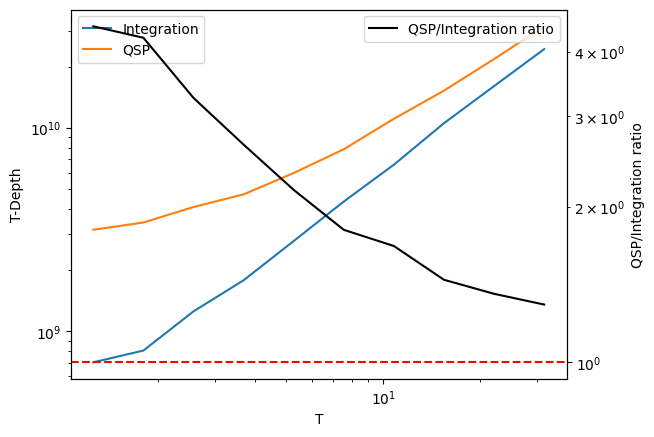

In [142]:
# plot d_qsp vs d_int where all are constants, but T is running like 1,10,100,1000,10000
d_int_values = []
d_qsp_values = []

values = np.logspace(0.1, 1.5, 10)

for T_val in values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T_val,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T_val,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(values, d_int_values, label='Integration')
plt.plot(values, d_qsp_values, label='QSP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T')
plt.ylabel('T-Depth')
plt.legend()

plt.twinx()
plt.plot(values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')

plt.yscale('log')

plt.axhline(1, color='red', linestyle='--')

plt.legend()
plt.show()

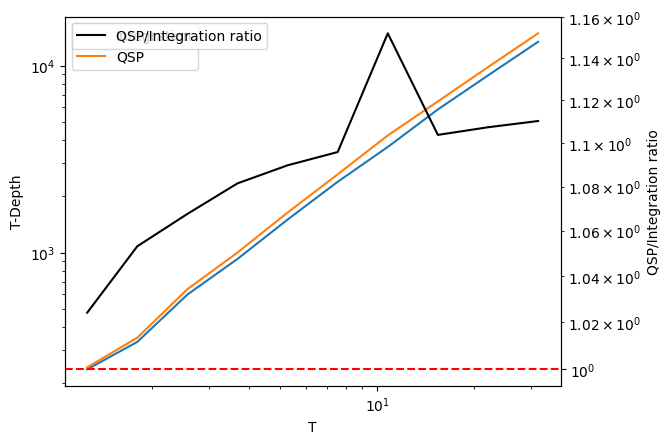

In [143]:
# plot d_qsp vs d_int where all are constants, but T is running like 1,10,100,1000,10000
d_int_values = []
d_qsp_values = []

values = np.logspace(0.1, 1.5, 10)

for T_val in values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T_val,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_arithmetic

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T_val,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_arithmetic

    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(values, d_int_values, label='Integration')
plt.plot(values, d_qsp_values, label='QSP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T')
plt.ylabel('T-Depth')
plt.legend()

plt.twinx()
plt.plot(values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')

plt.yscale('log')

plt.axhline(1, color='red', linestyle='--')

plt.legend()
plt.show()

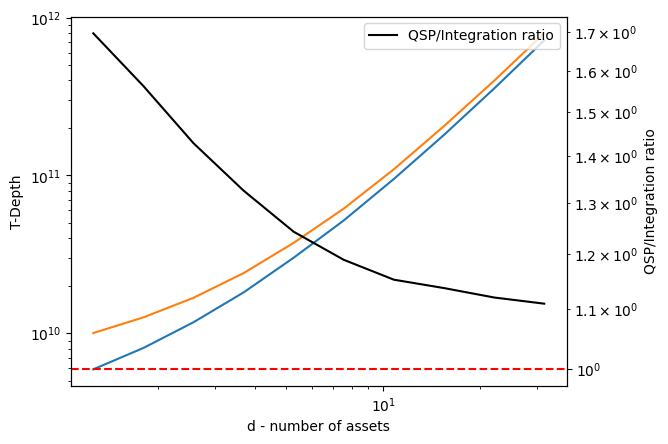

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# plot d_qsp vs d_int where all are constants, but T is running like 1,10,100,1000,10000
d_int_values = []
d_qsp_values = []

values = np.logspace(0.1, 1.5, 10)

for d_val in values:

    d_int = Complexity(
        method=isp_method,
        d_=d_val,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_qsp = Complexity(
        method=competitor_method,
        d_=d_val,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(values, d_int_values, label='Integration')
plt.plot(values, d_qsp_values, label='QSP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d - number of assets')
plt.ylabel('T-Depth')

plt.twinx()
plt.plot(values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')

plt.yscale('log')

#draw horizontal line at 1
plt.axhline(1, color='red', linestyle='--')

plt.legend()
plt.show()

## Sigma swipe

For small $\sigma$ the truncation is relevant, and rescaling becomes smaller and smaller

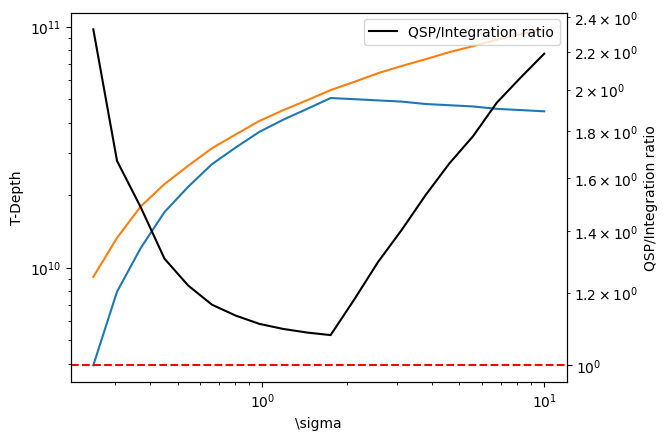

In [150]:
sigma_values = np.logspace(-0.6, 1, 20)
d_int_values = []
d_qsp_values = []


for sig_val in sigma_values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_val,
        e_payoff_=e_total
    ).depth_total()

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_val,
        e_payoff_=e_total
    ).depth_total()
    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(sigma_values, d_int_values, label='Integration')
plt.plot(sigma_values, d_qsp_values, label='QSP')
plt.xlabel('\sigma')
plt.xscale('log')
plt.ylabel('T-Depth')
plt.yscale('log')

plt.twinx()
plt.plot(sigma_values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')
plt.yscale('log')

plt.axhline(1, color='red', linestyle='--')

plt.legend()
plt.show()

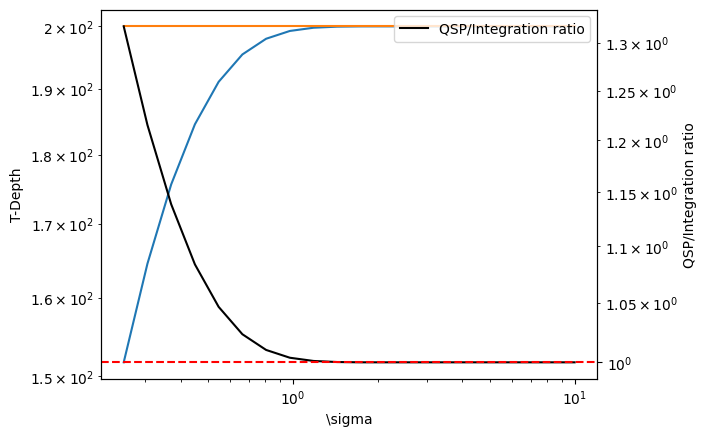

In [151]:
sigma_values = np.logspace(-0.6, 1, 20)
d_int_values = []
d_qsp_values = []


for sig_val in sigma_values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_val,
        e_payoff_=e_total
    ).rescaling

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_val,
        e_payoff_=e_total
    ).rescaling
    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(sigma_values, d_int_values, label='Integration')
plt.plot(sigma_values, d_qsp_values, label='QSP')
plt.xlabel('\sigma')
plt.xscale('log')
plt.ylabel('T-Depth')
plt.yscale('log')

plt.twinx()
plt.plot(sigma_values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')
plt.yscale('log')

plt.axhline(1, color='red', linestyle='--')

plt.legend()
plt.show()

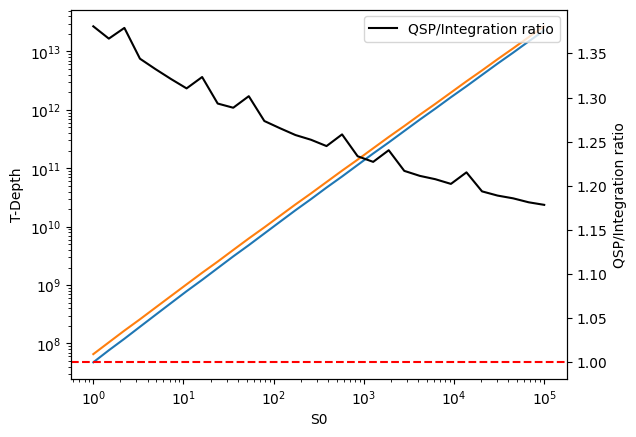

In [30]:
# plot d_qsp vs d_int where all are constants, but S_max-K is running like 1,10,100,1000,10000
S0_values = np.logspace(0, 5, 30)
d_int_values = []
d_qsp_values = []

minimal_d_integ = 1E30


for S0_val in S0_values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T,
        S0_=S0_val,
        K_=S0_val,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T,
        S0_=S0_val,
        K_=S0_val,
        sigma_=sig_qsp,
        e_payoff_=e_total
    ).depth_total()

    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

    # d_int_values.append(d_int)
    # d_qsp_values.append(d_qsp)


plt.plot(S0_values, d_int_values, label='Integration')
plt.plot(S0_values, d_qsp_values, label='QSP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S0')
plt.ylabel('T-Depth')

plt.twinx()
plt.plot(S0_values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')
plt.legend()

plt.axhline(1, color='red', linestyle='--')
#
# w_t = float(integ_complexity.valued_version(new_values_map).w)
# SIGMA_t = float(integ_complexity.valued_version(new_values_map).SIGMA)
# S0_makes_S_min_near_K_t = float(new_values_map_min_d_integ[K]/np.exp(-w_t*SIGMA_t))
# plt.axvline(S0_makes_S_min_near_K_t, color='red')

plt.show()

In [31]:
# let's plot a graph showing the convergance of Smax, Smin w when S0 makes S_min near K
# compexity_integ = Complexity(
#     method=Method.INTEGRATION,
#     d_=new_values_map_min_d_integ[d],
#     T_=new_values_map_min_d_integ[T],
#     S0_=S0_makes_S_min_near_K_t,
#     K_=new_values_map_min_d_integ[K],
#     sigma_=new_values_map_min_d_integ[SIGMA],
#     e_payoff_=new_values_map_min_d_integ[e_payoff]
# )


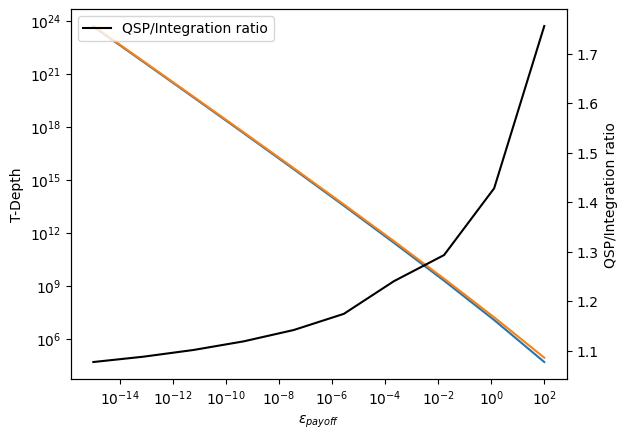

In [32]:
# same for e_payoff=[1E-1, 1E-2,1E-3,1E-4,1E-5,1E-6]
# affecting mainly on SP and number of QAE
# on NQAE - affecting the same growing together
# On SP affect significantly the SP, so it makes it more dominant relatively to the amplitude loading, so a bit better for QSP
e_payoff_values = np.logspace(-15, 2, 10)
d_int_values = []
d_qsp_values = []

for e_payoff_val in e_payoff_values:

    d_int = Complexity(
        method=isp_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_payoff_val
    ).depth_total()

    d_qsp = Complexity(
        method=competitor_method,
        d_=d,
        T_=T,
        S0_=S0,
        K_=S0,
        sigma_=sig_qsp,
        e_payoff_=e_payoff_val
    ).depth_total()
    d_int_values.append(d_int)
    d_qsp_values.append(d_qsp)

plt.plot(e_payoff_values, d_int_values, label='Integration')
plt.plot(e_payoff_values, d_qsp_values, label='QSP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\epsilon_{payoff}$')
plt.ylabel('T-Depth')


plt.twinx()
plt.plot(e_payoff_values, np.array(d_qsp_values)/np.array(d_int_values), label='QSP/Integration ratio', color='black')
plt.ylabel('QSP/Integration ratio')

plt.legend()
plt.show()

In [33]:
# now we will show a scan in 2D of the parameters, T and S_max-K
# plot is on meshgrid of T and S_max-K

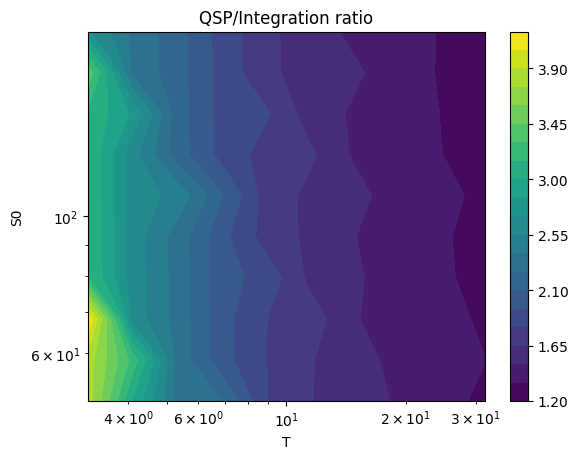

In [158]:
T_values = np.logspace(0.5, 1.5, 10)
S_values = np.logspace(1.7, 2.3, 10)
T_mesh, S_mesh = np.meshgrid(T_values, S_values)
d_int_values = np.zeros_like(T_mesh)
d_qsp_values = np.zeros_like(T_mesh)

for i in range(len(T_values)):
    for j in range(len(S_values)):

        d_int = Complexity(
            method=isp_method,
            d_=d,
            T_=T_values[i],
            S0_=S_values[j],
            K_=S_values[j]*1,
            sigma_=sig_qsp,
            e_payoff_=e_total
        ).depth_total()

        d_qsp = Complexity(
            method=competitor_method,
            d_=d,
            T_=T_values[i],
            S0_=S_values[j],
            K_=S_values[j]*1,
            sigma_=sig_qsp,
            e_payoff_=e_total
        ).depth_total()

        d_int_values[j,i] = d_int
        d_qsp_values[j,i] = d_qsp

# ratio
d_ratio_values = d_qsp_values/d_int_values
plt.contourf(T_mesh, S_mesh, d_ratio_values, levels=20)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T')
plt.ylabel('S0')
plt.title('QSP/Integration ratio')
# mark red when ratio <1
plt.contour(T_mesh, S_mesh, d_ratio_values, levels=[1], colors='red')
plt.show()

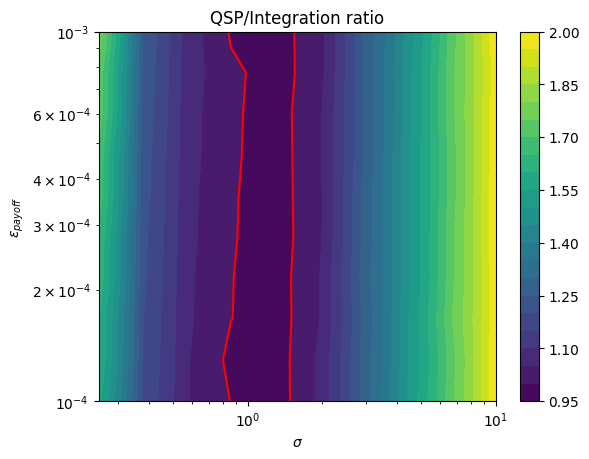

In [162]:
# the same for e_payoff and k
sigma_values = np.logspace(-0.6, 1, 10)
e_payoff_values = np.logspace(-3, -4, 10)
sigma_mesh, e_mesh = np.meshgrid(sigma_values, e_payoff_values)
d_int_values = np.zeros_like(sigma_mesh)
d_qsp_values = np.zeros_like(sigma_mesh)

for i in range(len(sigma_values)):
    for j in range(len(e_payoff_values)):
        # try:

        d_int = Complexity(
            method=isp_method,
            d_=d,
            T_=T,
            S0_=S0,
            K_=S0*1.1,
            sigma_=sigma_values[i],
            e_payoff_=e_payoff_values[j]
        ).depth_total()

        d_qsp = Complexity(
            method=competitor_method,
            d_=d,
            T_=T,
            S0_=S0,
            K_=S0*1.1,
            sigma_=sigma_values[i],
            e_payoff_=e_payoff_values[j]
        ).depth_total()
        d_int_values[j,i] = d_int
        d_qsp_values[j,i] = d_qsp
        # except:
        #     d_int_values[j,i] = 1E8
        #     d_qsp_values[j,i] = 1E10

# ratio
d_ratio_values = d_qsp_values/d_int_values
plt.contourf(sigma_mesh, e_mesh, d_ratio_values, levels=20)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\sigma$')
plt.ylabel('$\epsilon_{payoff}$')
plt.title('QSP/Integration ratio')

# plot the ratio=1 line
plt.contour(sigma_mesh, e_mesh, d_ratio_values, levels=[1], colors='red')
plt.show()

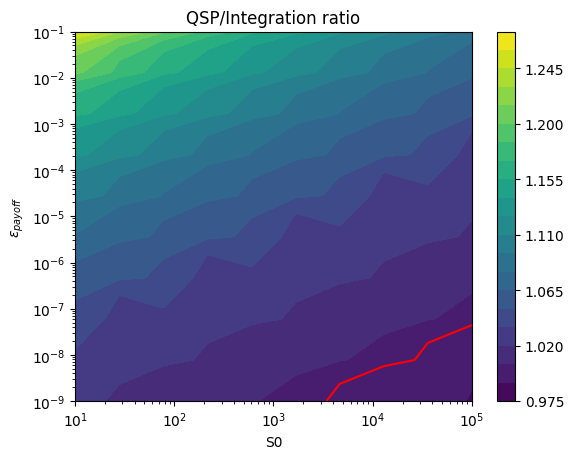

In [36]:
#TODO change to ... Smin
# the same for e_payoff and S_max-K
S_values = np.logspace(1, 5, 10)
e_payoff_values = np.logspace(-1, -9, 10)
S_mesh, e_mesh = np.meshgrid(S_values, e_payoff_values)
d_int_values = np.zeros_like(S_mesh)
d_qsp_values = np.zeros_like(S_mesh)

for i in range(len(S_values)):
    for j in range(len(e_payoff_values)):


        d_int = Complexity(
            method=isp_method,
            d_=d,
            T_=T,
            S0_=S_values[i],
            K_=S_values[i]*1.1,
            sigma_=sig_qsp,
            e_payoff_=e_payoff_values[j]
        ).depth_total()

        d_qsp = Complexity(
            method=competitor_method,
            d_=d,
            T_=T,
            S0_=S_values[i],
            K_=S_values[i]*1.1,
            sigma_=sig_qsp,
            e_payoff_=e_payoff_values[j]
        ).depth_total()
        d_int_values[j,i] = d_int
        d_qsp_values[j,i] = d_qsp

# ratio
d_ratio_values = d_qsp_values/d_int_values
plt.contourf(S_mesh, e_mesh, d_ratio_values, levels=20)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S0')
plt.ylabel('$\epsilon_{payoff}$')
plt.title('QSP/Integration ratio')
#plot the ratio=1 line
plt.contour(S_mesh, e_mesh, d_ratio_values, levels=[1], colors='red')
plt.show()

/var/folders/jr/6j7pq0l116j1jh3gfddm6v940000gn/T/ipykernel_50797/2627071167.py:119: RuntimeWarning: invalid value encountered in log
  iqae_degradation_factor = np.log((2/self.alpha) * np.log2(np.pi / self.error_prob))


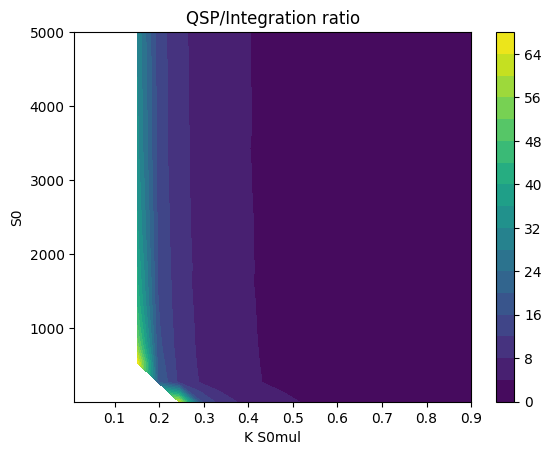

In [39]:
# mesh for K and S0
K_values_S0_mul = np.linspace(0.01, 0.9, 20)
S_values = np.linspace(1, 5000, 20)
K_mesh, S_mesh = np.meshgrid(K_values_S0_mul, S_values)
d_int_values = np.zeros_like(K_mesh)
d_qsp_values = np.zeros_like(K_mesh)

for i in range(len(K_values_S0_mul)):
    for j in range(len(S_values)):

        d_int = Complexity(
                method=isp_method,
                d_=d,
                T_=T,
                S0_=S_values[j],
                K_=S_values[j]*K_values_S0_mul[i],
                sigma_=sig_qsp,
                e_payoff_=e_total
            ).depth_total()
        if d_int is None:
            d_int = 1E20

        d_qsp = Complexity(
            method=competitor_method,
            d_=d,
            T_=T,
            S0_=S_values[j],
            K_=S_values[j]*K_values_S0_mul[i],
            sigma_=sig_qsp,
            e_payoff_=e_total
        ).depth_total()

        d_int_values[j,i] = d_int
        d_qsp_values[j,i] = d_qsp

# ratio
d_ratio_values = d_qsp_values/d_int_values
plt.contourf(K_mesh, S_mesh, d_ratio_values, levels=20)
plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('K S0mul')
plt.ylabel('S0')
plt.title('QSP/Integration ratio')

# #draw K=S0 line
# plt.plot(S_values, S_values, color='black')

# #plot the ratio=1 line
# plt.contour(K_mesh, S_mesh, d_ratio_values, levels=[1], colors='red')

plt.show()